In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

In [68]:
x = np.random.rand(100)+np.random.randint(-6,3,100)

In [69]:
x

array([-5.40811927,  0.84268532, -5.14452888, -2.08038795, -0.28270456,
       -4.9083528 , -0.96664552, -2.71846652, -4.5567125 , -0.87047044,
       -1.78353785,  1.12126039, -0.93917011, -2.92952547, -0.35527451,
        0.1719554 , -4.82683967, -0.01034696,  2.49180128, -2.72551395,
       -1.71101705,  2.64796969, -3.45260001,  2.5736721 , -4.37441417,
       -3.05460977, -5.37200231,  1.66341285,  0.15111161, -0.95623529,
       -0.66200614, -5.24445504, -0.47266918, -0.7102206 ,  0.3344191 ,
       -3.58350549, -2.84878466, -2.827498  , -5.22289907,  1.05681148,
       -4.15662876,  2.88526509,  1.63549927,  2.40028763,  0.51738657,
       -0.18371279, -3.79878489,  0.96818248,  1.10470261, -2.25508111,
       -1.80485515, -3.88822847, -1.02315409,  1.0706928 , -0.92035159,
       -5.8084754 ,  0.40541882, -5.54306409, -3.21449939,  0.71687745,
       -3.29167435, -1.33638572,  0.98531848, -1.45102599, -3.33619949,
        1.08621658, -1.77072347, -5.11897132, -3.39018182,  1.48

In [70]:
y =  0.3*x**2 + 2*x + 5+ np.random.randn(100)

In [71]:
y

array([ 1.74221057,  6.02275814,  3.46554405,  1.51058499,  4.48510141,
        2.73912092,  2.05280595,  1.17315566,  1.05773366,  3.60353087,
        2.62526527,  7.46864612,  3.31324894,  1.84348587,  4.20671251,
        6.96060922,  1.71299885,  4.35399924, 11.54245961,  2.28138329,
        1.75772787, 12.00893583,  0.76613749, 13.12123054,  3.15632294,
        0.5707983 ,  3.97094276, 10.11640397,  6.42982068,  3.58256112,
        2.4482015 ,  2.62273245,  6.01608792,  3.43495882,  6.91733758,
        1.50016624,  3.37403292,  2.27064821,  1.13785248,  8.08124435,
        1.03679882, 12.73289509, 10.07417472, 10.19640598,  5.66214484,
        4.88757881,  1.88513941,  8.87405188,  8.29076063,  3.35194227,
        1.97050367,  1.0422756 ,  3.72595062,  7.01685366,  3.98309575,
        3.98178942,  8.9943535 ,  4.53042555,  1.51120943,  6.46548182,
        1.27575329,  2.90631059,  7.57688471,  3.64424025,  2.71496357,
        7.27516051,  2.11746485,  2.99520163,  2.13613552,  8.35

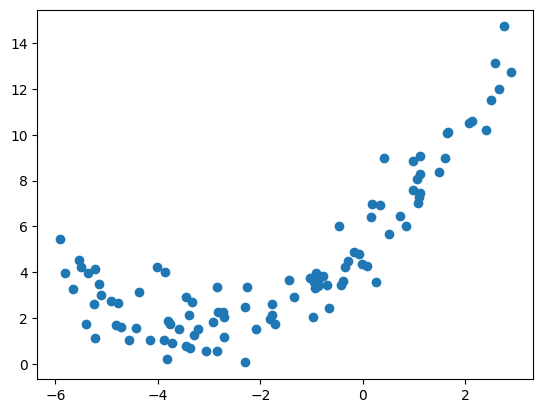

In [72]:
plt.scatter(x,y)

In [28]:
def generate_num(a,b,limit):
    x= np.random.rand(limit)+np.random.randint(a,b,limit)
    y = 0.3*x**2 + 2*x + 5+ np.random.randn(limit)

    return x,y

In [73]:
generate_num(-6,3,100)

(array([ 1.24835097, -5.05441544, -5.35589819, -2.27412765,  2.67091045,
        -2.00521446, -3.36964409,  1.08889211,  0.93920763, -5.55241712,
        -3.30640689, -5.01944948,  2.00898406, -4.42847109, -3.33484247,
         0.985635  ,  1.66416761, -3.00367964, -1.46083874,  2.52397309,
         0.24812292, -2.41236248, -4.45177336, -4.49365236, -1.45873777,
         0.71664599, -1.89068553, -4.91506067,  0.14352976, -4.1843913 ,
         0.70146615,  0.45766576, -3.75146862, -5.96717785, -3.82295547,
        -2.06858859, -3.27813469, -0.22370899, -3.65006806, -3.69094992,
        -4.88213161, -0.8200296 , -4.41078263, -1.67910147,  1.33846062,
        -4.01578819,  1.8817584 , -3.31290193, -0.24434297, -3.41448727,
        -2.23455539, -3.15742221,  0.31933   ,  1.90948164,  1.98587293,
        -4.42102549,  0.91075234, -4.48177419, -1.65052287,  0.61588541,
        -0.57866137, -4.70505884, -4.88420529, -5.124459  ,  1.72880041,
        -1.86106795, -0.97835059,  1.77338266, -1.4

In [31]:
reg = LinearRegression()

In [89]:
n,m = generate_num(-10,10,100)

train_x, test_x, train_y, test_y = train_test_split(n,m, test_size=0.3)

In [90]:
reg.fit(train_x.reshape(-1,1),train_y.reshape(-1,1))

LinearRegression()

In [91]:
y_pred = reg.predict(train_x.reshape(-1,1))

In [92]:
def regSummary(y_true, y_pred):
    return{
        "r2_score": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": math.sqrt(mean_squared_error(y_true, y_pred))
    }

In [93]:
regSummary(train_y, y_pred)

{'r2_score': 0.5830253916053585,
 'mae': 7.59996115428741,
 'mse': 75.48003118319367,
 'rmse': 8.687924446218076}

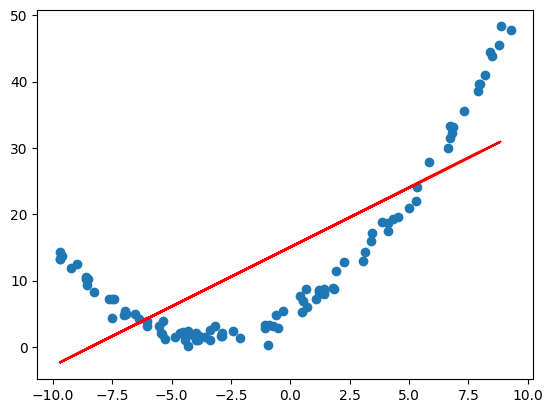

In [94]:
plt.scatter(n,m)
plt.plot(train_x, y_pred, color='red')

In [96]:
y.std()

3.2553084256724802